In [1]:
import sys
import os
import glob
import collections
import shutil
import subprocess

import numpy as np
import pandas as pd

from openeye import oechem

from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression

from textwrap import wrap
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

%matplotlib inline

%config IPCompleter.greedy=True

In [2]:
CWD = os.getcwd()

In [3]:
try:
    from pfabnet import base
except ModuleNotFoundError as e:
    os.chdir(os.getcwd() + os.sep + '..')
    
from pfabnet import base

In [4]:
from pfabnet.base import ENTITY_KEY, VISCOSITY_KEY

In [5]:
BASE_DIR = os.path.dirname(base.get_file_path()) + '/../'
DATA_DIR = os.path.join(BASE_DIR, 'data')
HM_DIR = os.path.join(DATA_DIR, 'hm')

In [6]:
with open('pfabnet/sbatch_tmpl.sh', 'r') as fptr:
    sbatch_tmpl = fptr.read()
    
print(sbatch_tmpl)

#!/bin/bash -l
#SBATCH -e %j.err
#SBATCH -o %j.out
#SBATCH --nodes=1
#SBATCH --gres=gpu:v100:1
#SBATCH --mem=32gb
#SBATCH --wait



### Generate test set attributions and significant attribution thresholds

In [7]:
sbatch_script = sbatch_tmpl + '#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=attribution\n\n'
sbatch_script += 'python pfabnet/generate_testset_attributions.py --test_data_file $1 --homology_model_dir $2 '
sbatch_script += '--PfAbNet_model_dir $3 --PfAbNet_model_prefix $4 '
sbatch_script += '--output_attribution_scores $5 --output_attribution_threshold $6 --esp_dir $7 --NX $8 --grid_dim $9 --grid_spacing ${10} --shell_width ${11}\n'

with open('sbatch_attribution.sh', 'w') as fptr:
    fptr.write(sbatch_script)

!mkdir -p models/pdgf38/attributions
!mkdir -p models/ab21/attributions
    
script_file = 'gen_attribution.sh'
with open(script_file, 'w') as fptr:
    NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH = 1, 96, 0.75, 2.0
    fptr.write('sbatch --export=ALL sbatch_attribution.sh %s %s %s %s %s %s %s %d %d %.2f %.1f &\n' 
               % ('data/Ab21.csv', 'data/hm/', 'models/pdgf38/', 'PfAbNet-PDGF38', 
                  'models/pdgf38/attributions/pdgf38_attributions.npy', 'models/pdgf38/attributions/pdgf38_attribution_threshold.npy', 
                  'data/hm/esp/', NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH))
    fptr.write('sbatch --export=ALL sbatch_attribution.sh %s %s %s %s %s %s %s %d %d %.2f %.1f &\n' 
               % ('data/PDGF38.csv', 'data/hm/', 'models/ab21/', 'PfAbNet-Ab21', 
                  'models/ab21/attributions/ab21_attributions.npy', 'models/ab21/attributions/ab21_attribution_threshold.npy', 
                  'data/hm/esp/', NX, GRID_DIM, GRID_SPACING, SHELL_WIDTH)) 
               
    fptr.write('wait\n')
               
!chmod u+rwx gen_attribution.sh          
#!./gen_attribution.sh


Ab21, attribution score std:  0.00033690651260234457
PDGF, attribution score std:  0.00041338101512461087


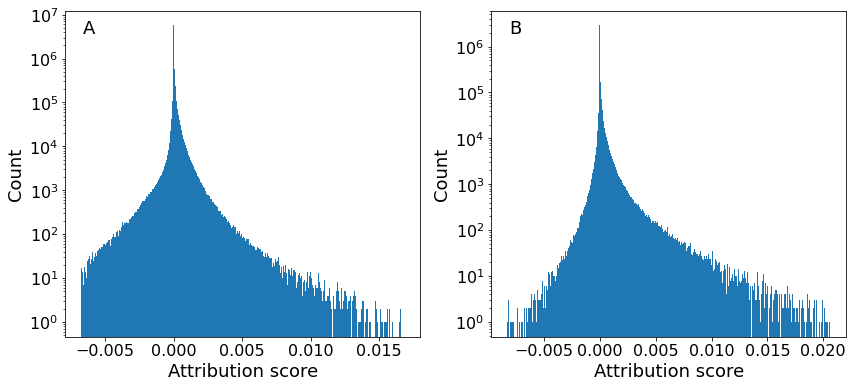

In [12]:
Ab21_attr_arr = np.load('models/ab21/attributions/ab21_attributions.npy')
Ab21_attr_std = np.std(Ab21_attr_arr)#[np.abs(Ab21_attr_arr)>1e-6])
Ab21_bins = np.arange(-20*Ab21_attr_std, 50*Ab21_attr_std, Ab21_attr_std/10.0)
print('Ab21, attribution score std: ', Ab21_attr_std)

PDGF_attr_arr = np.load('models/pdgf38/attributions/pdgf38_attributions.npy')
PDGF_attr_std = np.std(PDGF_attr_arr)
PDGF_bins = np.arange(-20*PDGF_attr_std, 50*PDGF_attr_std, PDGF_attr_std/10.0)
print('PDGF, attribution score std: ', PDGF_attr_std)

FONT_SIZE = 18
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].hist(Ab21_attr_arr, bins=Ab21_bins);
axes[0].set_yscale('log')
axes[0].set_xlabel('Attribution score', fontsize=FONT_SIZE)
axes[0].set_ylabel('Count', fontsize=FONT_SIZE)
axes[0].tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
axes[0].text(0.05, 0.93, 'A', transform=axes[0].transAxes, fontsize=FONT_SIZE)

axes[1].hist(PDGF_attr_arr, bins=PDGF_bins);
axes[1].set_yscale('log')
axes[1].set_xlabel('Attribution score', fontsize=FONT_SIZE)
axes[1].set_ylabel('Count', fontsize=FONT_SIZE)
axes[1].tick_params(axis='both', which='major', labelsize=FONT_SIZE-2)
axes[1].text(0.05, 0.93, 'B', transform=axes[1].transAxes, fontsize=FONT_SIZE);

plt.savefig('Suppl_fig11.png', bbox_inches='tight', dpi=300)

In [11]:
significant_attribution_threshold_pdgf38 = np.load('models/pdgf38/attributions/pdgf38_attribution_threshold.npy')
significant_attribution_threshold_ab21 = np.load('models/ab21/attributions/ab21_attribution_threshold.npy')
print('significant attribution threshold PDGF38: %f, Ab21: %f' % (significant_attribution_threshold_pdgf38, significant_attribution_threshold_ab21))

significant attribution threshold PDGF38: 0.000413, Ab21: 0.000337


### Generate attribution molecules

In [13]:
sbatch_script = sbatch_tmpl + '#SBATCH --array=0-40\n#SBATCH --time=0-4:00:00\n#SBATCH --ntasks-per-node=1\n#SBATCH --job-name=attribution\n\n'
sbatch_script += 'python pfabnet/generate_attributions.py --test_data_file $1 --homology_model_dir $2 --reference_structure_file data/hm/mAb1.pdb '
sbatch_script += '--PfAbNet_model_dir $3 --PfAbNet_model_prefix $4 '
sbatch_script += '--esp_dir $5 --significant_attribution_threshold $6 --output_attribution_dir $7 --process_structure_index $SLURM_ARRAY_TASK_ID\n'

with open('sbatch_attribution2.sh', 'w') as fptr:
    fptr.write(sbatch_script)

script_file = 'gen_attribution2.sh'
with open(script_file, 'w') as fptr:
    
    fptr.write('sbatch --export=ALL sbatch_attribution2.sh %s %s %s %s %s %f %s &\n' 
               % ('data/Ab21.csv', 'data/hm/', 'models/pdgf38/', 'PfAbNet-PDGF38', 
                  'data/hm/esp/', significant_attribution_threshold_pdgf38, 'models/pdgf38/attributions'))
    fptr.write('sbatch --export=ALL sbatch_attribution2.sh %s %s %s %s %s %f %s &\n' 
               % ('data/PDGF38.csv', 'data/hm/', 'models/ab21/', 'PfAbNet-Ab21', 
                  'data/hm/esp/', significant_attribution_threshold_ab21, 'models/ab21/attributions'))
               
    fptr.write('wait\n')
               
!chmod u+rwx gen_attribution2.sh          
#!./gen_attribution2.sh

## % significant attribution points

In [14]:
def get_mean_significant_attr_ptrs(test_set):
    attr_mol_files = glob.glob('models/%s/attributions/*.oeb.gz' % test_set)
    significant_attr_pts = []
    for f in attr_mol_files:
        ifs = oechem.oemolistream(f)
        mol = oechem.OEGraphMol()
        oechem.OEReadMolecule(ifs, mol)
        ifs.close()

        significant_attr_pts.append(mol.NumAtoms())
    
    return np.mean(np.array(significant_attr_pts))

In [15]:
significant_attr_pts_ab21 = get_mean_significant_attr_ptrs('pdgf38')
significant_attr_pts_pdgf38 = get_mean_significant_attr_ptrs('ab21')

frac_ab21 = 100*significant_attr_pts_ab21/np.power(96,3)
frac_pdgf38 = 100*significant_attr_pts_pdgf38/np.power(96,3)
print('percentage attribution points - Ab21: %.2f, PDGF38: %.2f' % (frac_ab21, frac_pdgf38))

percentage attribution points - Ab21: 0.14, PDGF38: 0.21


## Patch-size distribution in test set molecules

In [19]:
MIN_PATCH_SIZE = 10

def get_molecule(mol_file):
    ifs = oechem.oemolistream(mol_file)
    mol = oechem.OEGraphMol()
    oechem.OEReadMolecule(ifs, mol)
    ifs.close()
    
    return mol

def create_patches(mol, ab_sets, remove_existing=False):
    def add_atom_to_set(atom1, atom2, ab_sets, remove_existing=False):
        for i, ab_set in enumerate(ab_sets):
            if ab_set.HasAtom(atom1):
                ab_set.AddAtom(atom2)
                if remove_existing:
                    for j in range(i+1, len(ab_sets)):
                        if ab_sets[j].HasAtom(atom1) or ab_sets[j].HasAtom(atom2):
                            for jatom in ab_sets[j].GetAtoms():
                                ab_set.AddAtom(jatom)
                            ab_sets[j].Clear()
                return True
        return False
    
    nbrs = oechem.OEGetNearestNbrs(mol, 1.51)
    for nbr in nbrs:
        if add_atom_to_set(nbr.GetBgn(), nbr.GetEnd(), ab_sets, remove_existing):
            continue
        if add_atom_to_set(nbr.GetEnd(), nbr.GetBgn(), ab_sets, remove_existing):
            continue
        ab_set = oechem.OEAtomBondSet()
        ab_set.AddAtom(nbr.GetBgn())
        ab_set.AddAtom(nbr.GetEnd())
        ab_sets.append(ab_set)
        
    ab_sets2 = []
    for ab_set in ab_sets:
        ab_sets2.append((ab_set.NumAtoms(), ab_set))
        
    ab_sets2.sort(key = lambda x: x[0], reverse=True)
    ab_sets2 = [ab_set for _, ab_set in ab_sets2 if ab_set.NumAtoms() > 0]
    
    return ab_sets2

def get_patch_mols(mol, delete_atom_pred=oechem.OEIsNitrogen()):
    for atom in mol.GetAtoms(delete_atom_pred):
        mol.DeleteAtom(atom)
        
    ab_sets = []
    ab_sets2 = create_patches(mol, ab_sets)
    # ab_sets3 = create_patches(mol, ab_sets2, True)
    
    patch_mols = []
    for ab_set in ab_sets2:
        if ab_set.NumAtoms() < MIN_PATCH_SIZE:
            continue
        mol = oechem.OEGraphMol()
        oechem.OESubsetMol(mol, ab_set)
        patch_mols.append((mol.NumAtoms(), mol))
        
    patch_mols.sort(key = lambda x: x[0], reverse=True)
    patch_mols = [mol for _, mol in patch_mols]
    
    return patch_mols

def get_patch_sizes(mol_files, delete_atom_pred=oechem.OEIsNitrogen(),
                    save_patches=False, file_suffix='_pos_attr'):
    MAX_NUM_PATCH = 5
    patch_data = collections.defaultdict(list)
    for mol_file in mol_files:
        mol = get_molecule(mol_file)
        patch_mols = get_patch_mols(mol, delete_atom_pred)

        mol_file_base = os.path.basename(mol_file).split('_')[0]
        if mol_file_base not in patch_data[ENTITY_KEY]:
            patch_data[ENTITY_KEY].append(mol_file_base)
            
        for i, patch_mol in enumerate(patch_mols):
            if i >= MAX_NUM_PATCH:
                break            
            patch_data['%s_PATCH_SIZE%s_%d' % (mol_file_base, file_suffix, (i+1))].append(patch_mol.NumAtoms())

        if save_patches:
            mol2_file = mol_file.split('.oeb.gz')[0] + file_suffix + '.mol2'
            ofs = oechem.oemolostream(mol2_file)
            for patch_mol in patch_mols:
                oechem.OEWriteConstMolecule(ofs, patch_mol)
            ofs.close()
        
    patch_data2 = []
    for entity in patch_data[ENTITY_KEY]:
        data = {ENTITY_KEY: entity}
        for i in range(MAX_NUM_PATCH):
            patch_data_list = patch_data['%s_PATCH_SIZE%s_%d' % (entity, file_suffix, (i+1))]
            if len(patch_data_list) > 0:
                patch_data_arr = np.array(patch_data_list)
                data['PATCH_SIZE%s_%d' % (file_suffix, (i+1))] = np.mean(patch_data_arr)
                data['PATCH_SIZE%s_stderr_%d' % (file_suffix, (i+1))] = 1.96*np.std(patch_data_arr)/np.sqrt(len(patch_data_arr))
                
        patch_data2.append(data)
        
    return patch_data2

In [20]:
def plot_patch_distributions(df_patch, show_legends=True):
    FONT_SIZE = 19
    legends = ['Patch 1', 'Patch 2', 'Patch 3', 'Patch 4', 'Patch 5']

    ind = np.arange(0, len(df_patch))
    pos_cols = ['PATCH_SIZE_pos_attr_%d'%(i+1) for i in range(5)]
    pos_stderr_cols = ['PATCH_SIZE_pos_attr_stderr_%d'%(i+1) for i in range(5)]
    neg_cols = ['PATCH_SIZE_neg_attr_%d'%(i+1) for i in range(5)]
    neg_stderr_cols = ['PATCH_SIZE_neg_attr_stderr_%d'%(i+1) for i in range(5)]
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 5))
    
    width = 0.3
    bottom = 0
    CAP_SIZE = 3
    
    ind = np.arange(0, len(df_patch))
    df_patch1 = df_patch[pos_cols]
    df_patch1_stderr = df_patch[pos_stderr_cols]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    handles1 = []
    for col, stderr_col in zip(pos_cols, pos_stderr_cols):
        h = axes.bar(ind-width/2, df_patch1[col], width=width, 
                     bottom=bottom, yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE)
        handles1.append(h)
        bottom += df_patch1[col]
        
    bottom = 0
    df_patch1 = df_patch[neg_cols]
    df_patch1_stderr = df_patch[neg_stderr_cols]
    handles2 = []
    for enum, (col, stderr_col) in enumerate(zip(neg_cols, neg_stderr_cols)):
        h = axes.bar(ind+width/2, df_patch1[col], width=width, bottom=bottom, 
                     yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE, alpha=0.5, color=colors[enum])
        handles2.append(h)
        bottom += df_patch1[col]
    
    if show_legends:
        leg = axes.legend(handles=handles1, labels=legends, fontsize=FONT_SIZE-2, title='Positive attribution', loc=(0.05, 0.4))
        plt.setp(leg.get_title(),fontsize=FONT_SIZE-3)
        axes.add_artist(leg)
        leg2 = axes.legend(handles=handles2, labels=legends, fontsize=FONT_SIZE-2, title='Negative attribution', loc=(0.25, 0.4))
        plt.setp(leg2.get_title(),fontsize=FONT_SIZE-3)
    
    axes.tick_params(axis='y', which='major', labelsize=FONT_SIZE-3)
    axes.set_xticks(ind)
    axes.set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes.set_ylabel('Patch size (# attribution points)', fontsize=FONT_SIZE-1)
    axes.set_xlim([-2*width, len(ind)-2*width])

### Patch-size distribution in Ab21 set

In [21]:
mol_files = glob.glob('models/pdgf38/attributions/*.oeb.gz')
patch_sizes_ab21_pos_attr = get_patch_sizes(mol_files, oechem.OEIsNitrogen(), save_patches=True, file_suffix='_pos_attr')
patch_sizes_ab21_neg_attr = get_patch_sizes(mol_files, oechem.OEIsOxygen(), save_patches=True, file_suffix='_neg_attr')

df_patch_ab21_pos_attr = pd.DataFrame(patch_sizes_ab21_pos_attr)
df_patch_ab21_neg_attr = pd.DataFrame(patch_sizes_ab21_neg_attr)
df_patch_ab21 = df_patch_ab21_pos_attr.merge(df_patch_ab21_neg_attr, on=ENTITY_KEY)

df_ab21 = pd.read_csv('data/Ab21.csv')
df_patch_ab21 = df_ab21.merge(df_patch_ab21, on=ENTITY_KEY)
df_patch_ab21 = df_patch_ab21.sort_values(VISCOSITY_KEY)
df_patch_ab21.head()

,Entity,Viscosity_at_150,Isotype,N_hydrophobic Fv,N_hydrophobic mAb,N_hydrophilic Fv,N_hydrophilic mAb,HI_Fv,HI_mAb,SASA_phobic_Fv,...,PATCH_SIZE_neg_attr_1,PATCH_SIZE_neg_attr_stderr_1,PATCH_SIZE_neg_attr_2,PATCH_SIZE_neg_attr_stderr_2,PATCH_SIZE_neg_attr_3,PATCH_SIZE_neg_attr_stderr_3,PATCH_SIZE_neg_attr_4,PATCH_SIZE_neg_attr_stderr_4,PATCH_SIZE_neg_attr_5,PATCH_SIZE_neg_attr_stderr_5
13,mAb18,7.1,IgG1,84,496,117,706,1.256007,1.042884,4420.116699,...,17.825000,1.436868,13.800000,1.147479,12.571429,1.451069,12.000000,0.000000,10.000000,0.000000
18,mAb25,7.4,IgG1,77,480,125,724,1.073215,1.001049,4446.611328,...,15.214286,2.049732,11.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,mAb12,7.5,IgG1,87,492,120,726,1.171067,0.992760,5444.043945,...,83.639175,12.160538,40.677778,5.047639,25.233766,2.860415,19.339286,2.445134,17.076923,2.519230
14,mAb21,8.6,IgG1,80,486,119,710,1.187628,1.033930,3921.662598,...,70.879121,9.708321,20.383562,2.297658,13.847826,1.328363,12.000000,1.093776,11.500000,1.470000
4,mAb5,8.6,IgG1,89,504,112,700,1.273285,1.052817,5683.704590,...,99.515152,11.467231,30.902439,4.260754,17.571429,2.048952,14.295455,1.263992,13.181818,1.456501


In [22]:
df_patch_ab21_2 = df_patch_ab21.copy()
df_patch_ab21_2['PATCH_SIZE_pos_attr_top5'] = df_patch_ab21_2.apply(lambda x: x['PATCH_SIZE_pos_attr_1'] + x['PATCH_SIZE_pos_attr_2'] 
                                                                    + x['PATCH_SIZE_pos_attr_3'] + x['PATCH_SIZE_pos_attr_4'] 
                                                                    + x['PATCH_SIZE_pos_attr_5'], axis=1)
df_patch_ab21_high = df_patch_ab21_2[df_patch_ab21_2[VISCOSITY_KEY] > 90.0]
df_patch_ab21_low = df_patch_ab21_2[df_patch_ab21_2[VISCOSITY_KEY] < 90.0]
print('low: %d, top5: %d' % (np.mean(df_patch_ab21_low['PATCH_SIZE_pos_attr_top5'].values), np.mean(df_patch_ab21_high['PATCH_SIZE_pos_attr_top5'].values)))
ttest = stats.ttest_ind(df_patch_ab21_low['PATCH_SIZE_pos_attr_top5'].values, df_patch_ab21_high['PATCH_SIZE_pos_attr_top5'].values)
print('p-value: %.e' % ttest.pvalue)

low: 565, top5: 991
p-value: 7e-04


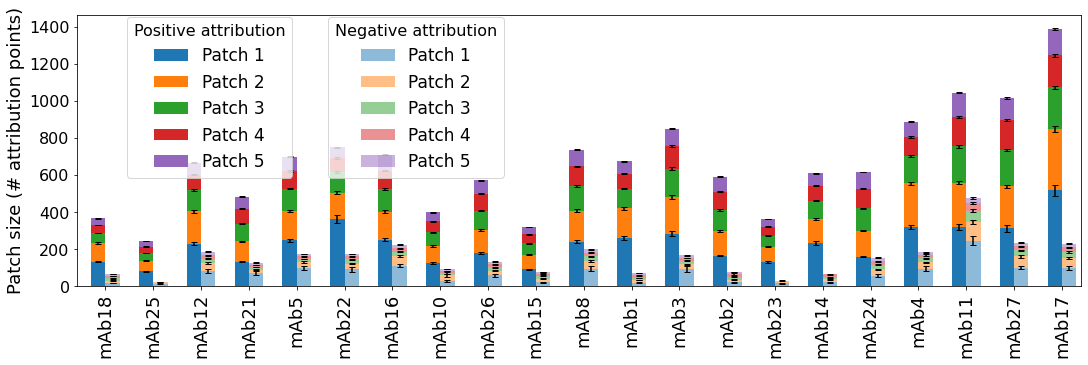

In [33]:
plot_patch_distributions(df_patch_ab21, True)
plt.savefig('Fig3I.png', bbox_inches='tight', dpi=300)

### Patch-size distribution in PDGF38 set

In [24]:
mol_files = glob.glob('models/ab21/attributions/*.oeb.gz')
patch_sizes_pdgf38_pos_attr = get_patch_sizes(mol_files, oechem.OEIsNitrogen(), save_patches=True, file_suffix='_pos_attr')
patch_sizes_pdgf38_neg_attr = get_patch_sizes(mol_files, oechem.OEIsOxygen(), save_patches=True, file_suffix='_neg_attr')

df_patch_pdgf38_pos_grad = pd.DataFrame(patch_sizes_pdgf38_pos_attr)
df_patch_pdgf38_neg_grad = pd.DataFrame(patch_sizes_pdgf38_neg_attr)
df_patch_pdgf38 = df_patch_pdgf38_pos_grad.merge(df_patch_pdgf38_neg_grad, on=ENTITY_KEY)

df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_patch_pdgf38 = df_pdgf38.merge(df_patch_pdgf38, on=ENTITY_KEY)
df_patch_pdgf38 = df_patch_pdgf38.sort_values(VISCOSITY_KEY)
df_patch_pdgf38.head()

,Entity,Viscosity_at_150,SCM,HC,LC,PATCH_SIZE_pos_attr_1,PATCH_SIZE_pos_attr_stderr_1,PATCH_SIZE_pos_attr_2,PATCH_SIZE_pos_attr_stderr_2,PATCH_SIZE_pos_attr_3,...,PATCH_SIZE_neg_attr_1,PATCH_SIZE_neg_attr_stderr_1,PATCH_SIZE_neg_attr_2,PATCH_SIZE_neg_attr_stderr_2,PATCH_SIZE_neg_attr_3,PATCH_SIZE_neg_attr_stderr_3,PATCH_SIZE_neg_attr_4,PATCH_SIZE_neg_attr_stderr_4,PATCH_SIZE_neg_attr_5,PATCH_SIZE_neg_attr_stderr_5
35,R2-020,10,-1363,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,322.66,23.011806,190.67,13.761072,126.70,...,147.757576,16.985653,63.724490,5.346983,31.228261,2.770401,21.530864,1.870607,15.640625,1.450970
21,R2-006,13,-1470,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,406.26,27.232162,237.39,15.900805,135.26,...,161.160000,13.044996,90.830000,7.641288,39.556701,5.131971,25.279070,3.148690,18.567164,2.329752
24,R2-009,19,-1469,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,318.97,20.797594,220.59,10.741626,156.63,...,168.400000,10.333532,96.310000,8.379530,41.914894,5.279698,26.164384,4.274528,17.836364,1.749280
33,R2-018,20,-1346,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGNSLGSYFVHWYQQKPGQSPVLV...,399.18,32.262057,199.42,13.883337,132.30,...,188.979798,19.106189,43.153846,5.675450,24.756410,2.709232,18.178571,2.108213,14.588235,1.329931
22,R2-007,21,-1433,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,362.79,31.431890,206.94,16.831524,132.12,...,157.680000,11.088816,91.663265,8.059278,27.531915,2.391009,19.013889,1.486290,15.450980,1.372074


In [25]:
df_patch_pdgf38_2 = df_patch_pdgf38.copy()
df_patch_pdgf38_2['PATCH_SIZE_pos_attr_top5'] = df_patch_pdgf38_2.apply(lambda x: x['PATCH_SIZE_pos_attr_1'] + x['PATCH_SIZE_pos_attr_2'] 
                                                                    + x['PATCH_SIZE_pos_attr_3'] + x['PATCH_SIZE_pos_attr_4'] 
                                                                    + x['PATCH_SIZE_pos_attr_5'], axis=1)
df_patch_pdgf38_high = df_patch_pdgf38_2[df_patch_pdgf38_2[VISCOSITY_KEY] > 90.0]
df_patch_pdgf38_low = df_patch_pdgf38_2[df_patch_pdgf38_2[VISCOSITY_KEY] < 90.0]
print('low: %d, high: %d' % (np.mean(df_patch_pdgf38_low['PATCH_SIZE_pos_attr_top5'].values), np.mean(df_patch_pdgf38_high['PATCH_SIZE_pos_attr_top5'].values)))
ttest = stats.ttest_ind(df_patch_pdgf38_low['PATCH_SIZE_pos_attr_top5'].values, df_patch_pdgf38_high['PATCH_SIZE_pos_attr_top5'].values)
print('p-value: %.e' % ttest.pvalue)

low: 876, high: 1328
p-value: 5e-08


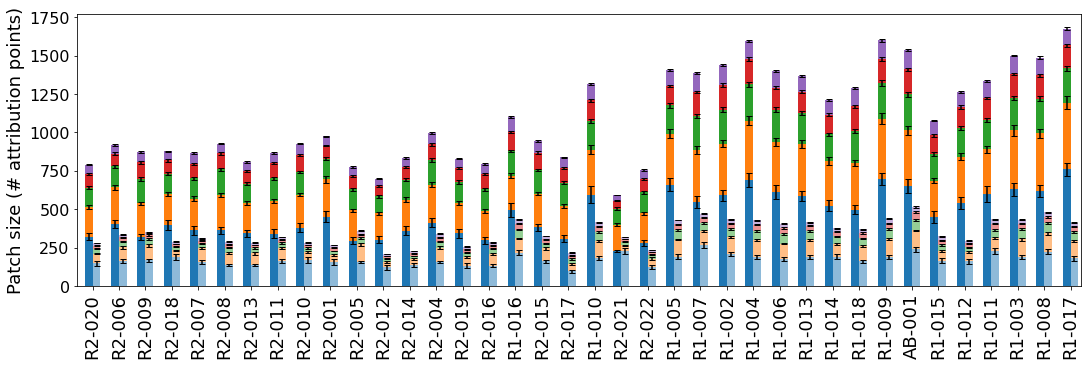

In [32]:
plot_patch_distributions(df_patch_pdgf38, False)
plt.savefig('Fig3J.png', bbox_inches='tight', dpi=300)

## Influence of proximal positive charges on positive attributions around sidechain carboxyl groups

In [27]:
MIN_PATCH_SIZE = 10

def attach_resid(atom):
    oeres = oechem.OEAtomGetResidue(atom)
    resid = '%s-%s%d' % (oeres.GetChainID(), oeres.GetName(), oeres.GetResidueNumber())
    atom.SetData('resid', resid)
        
# create a new molecule with only ASP and GLU carboxylates
def get_nc_mol(mol):
    abset = oechem.OEAtomBondSet()
    hv = oechem.OEHierView(mol)
    for hr in hv.GetResidues():
        resname = hr.GetResidueName()
        if oechem.OEGetResidueIndex(resname) == oechem.OEResidueIndex_ASP:
            for atom in hr.GetAtoms():
                pdb_index = oechem.OEGetPDBAtomIndex(atom)
                if pdb_index in [oechem.OEPDBAtomName_CG, oechem.OEPDBAtomName_OD1, 
                                 oechem.OEPDBAtomName_OD2]:
                    attach_resid(atom)
                    abset.AddAtom(atom)
        if oechem.OEGetResidueIndex(resname) == oechem.OEResidueIndex_GLU:
            for atom in hr.GetAtoms():
                pdb_index = oechem.OEGetPDBAtomIndex(atom)
                if pdb_index in [oechem.OEPDBAtomName_CD, oechem.OEPDBAtomName_OE1, 
                                 oechem.OEPDBAtomName_OE2]:
                    attach_resid(atom)
                    abset.AddAtom(atom)
                    
    nc_mol = oechem.OEGraphMol()
    oechem.OESubsetMol(nc_mol, abset)
    
    return nc_mol

# extend the input motif_mol by adding the neighboring atoms
def add_nearby_atoms(protein_mol, motif_mol, dist_thres=3.0):
    abset = oechem.OEAtomBondSet()
    nbrs = oechem.OEGetNearestNbrs(protein_mol, motif_mol, dist_thres)
    for nbr in nbrs:
        if nbr.GetBgn().IsHydrogen():
            continue        
        if nbr.GetDist2() < 1e-5:
            abset.AddAtom(nbr.GetEnd())
            continue
        abset.AddAtom(nbr.GetBgn())
        abset.AddAtom(nbr.GetEnd())
        
    for atom in abset.GetAtoms():
        if not atom.HasData('resid'):
            atom.SetData('resid', 'other')
    motif_mol2 = oechem.OEGraphMol()
    oechem.OESubsetMol(motif_mol2, abset)
    
    return motif_mol2

# create a new molecule containing positive charge centers
def get_pc_mol(mol):
    abset = oechem.OEAtomBondSet()
    hv = oechem.OEHierView(mol)
    for hr in hv.GetResidues():
        resname = hr.GetResidueName()
        if oechem.OEGetResidueIndex(resname) == oechem.OEResidueIndex_LYS:
            for atom in hr.GetAtoms():
                pdb_index = oechem.OEGetPDBAtomIndex(atom)
                if pdb_index == oechem.OEPDBAtomName_NZ:
                    abset.AddAtom(atom)
        if oechem.OEGetResidueIndex(resname) == oechem.OEResidueIndex_ARG:
            for atom in hr.GetAtoms():
                pdb_index = oechem.OEGetPDBAtomIndex(atom)
                if pdb_index in [oechem.OEPDBAtomName_CZ, 
                                 oechem.OEPDBAtomName_NH1, oechem.OEPDBAtomName_NH2]:
                    abset.AddAtom(atom)
                    
    pc_mol = oechem.OEGraphMol()
    oechem.OESubsetMol(pc_mol, abset)
    
    return pc_mol

# extract attribution patch mols that are with in 4 Angstrom of each input motif
def extract_matching_patch_mols(attrib_mol, motif_mol):
    nbrs = oechem.OEGetNearestNbrs(attrib_mol, motif_mol, 4)
    for nbr in nbrs:
        if not nbr.GetBgn().HasData('resid'):
            nbr.GetBgn().SetData('resid', nbr.GetEnd().GetData('resid'))
            nbr.GetBgn().SetData('dist', nbr.GetDist2())
        else:
            dist2 = nbr.GetBgn().GetData('dist')
            if nbr.GetDist2() < dist2:
                nbr.GetBgn().SetData('resid', nbr.GetEnd().GetData('resid'))
                nbr.GetBgn().SetData('dist', nbr.GetDist2())
            
    absets = collections.defaultdict(oechem.OEAtomBondSet)
    for atom in attrib_mol.GetAtoms():
        if atom.HasData('resid') and atom.GetData('resid') != 'other':
            absets[atom.GetData('resid')].AddAtom(atom)

    patch_mols = {}
    for k, abset in absets.items():
        patch_mol = oechem.OEGraphMol()
        oechem.OESubsetMol(patch_mol, abset)
        patch_mol.SetTitle(k)
        patch_mols[k] = patch_mol
    
    return patch_mols


def get_nbr_maps(nc_mol, pc_mol, threshold):
    nbrs = oechem.OEGetNearestNbrs(nc_mol, pc_mol, threshold)
    nbr_map = {}
    for nbr in nbrs:
        nbr_map[nbr.GetBgn().GetData('resid')] = True
        
    return nbr_map

def get_patch_intensities(mol_files):
    patch_data = collections.defaultdict(list)
    for mol_file in mol_files:
        protein_mol = get_molecule(mol_file)
        oechem.OEPerceiveResidues(protein_mol)
        nc_mol = get_nc_mol(protein_mol)
        nc_mol = add_nearby_atoms(protein_mol, nc_mol)
        pc_mol = get_pc_mol(protein_mol)
        nbr4 = get_nbr_maps(nc_mol, pc_mol, 3.5)
        nbr5 = get_nbr_maps(nc_mol, pc_mol, 5.0)

        # tmp = mol_file.split('esp96')
        attrib_file = mol_file.split('.pdb')[0] + '.oeb.gz'
        attrib_mol = get_molecule(attrib_file)
        matching_patch_mols = extract_matching_patch_mols(attrib_mol, nc_mol)
        
        attr_arr4 = []; attr_arr5 = []
        for k, patch_mol in matching_patch_mols.items():
            if k in nbr4:
                for atom in patch_mol.GetAtoms():
                    attr_arr4.append(atom.GetPartialCharge())
                break
            if k not in nbr5:
                for atom in patch_mol.GetAtoms():
                    attr_arr5.append(atom.GetPartialCharge())
                    
        if len(attr_arr4) == 0 or len(attr_arr5) == 0:
            continue
            
        attr_arr4 = np.array(attr_arr4)
        attr_arr5 = np.array(attr_arr5)
        attr_mean4 = np.mean(attr_arr4)
        attr_mean5 = np.mean(attr_arr5)
        

        entity = os.path.basename(mol_file).split('_')[0]
        if entity not in patch_data[ENTITY_KEY]:
            patch_data[ENTITY_KEY].append(entity)
            
        patch_data['%s_attr_proximal' % entity].append(attr_mean4)
        patch_data['%s_attr_proximal_N' % entity].append(len(attr_arr4))
        patch_data['%s_attr_distal' % entity].append(attr_mean5)
        patch_data['%s_attr_distal_N' % entity].append(len(attr_arr5))

    patch_data2 = []
    for entity in patch_data[ENTITY_KEY]:
        data = {ENTITY_KEY:entity}
        attr_arr = np.array(patch_data['%s_attr_proximal' % entity])
        data['attr_proximal'] = np.mean(attr_arr)
        data['attr_proximal_stderr'] = 1.96*np.std(attr_arr)/np.sqrt(len(attr_arr))
        data['attr_proximal_N'] = np.mean(np.array(patch_data['%s_attr_proximal_N' % entity]))
        attr_arr = np.array(patch_data['%s_attr_distal' % entity])
        data['attr_distal'] = np.mean(attr_arr)
        data['attr_distal_stderr'] = 1.96*np.std(attr_arr)/np.sqrt(len(attr_arr))   
        data['attr_distal_N'] = np.mean(np.array(patch_data['%s_attr_distal_N' % entity]))
        
        patch_data2.append(data)
        
    return patch_data2


def plot_patch_intensities(axes, df_patch, label=None, display_legends=True):
    FONT_SIZE = 18

    cols = ['attr_proximal', 'attr_distal']
    stderr_cols = ['attr_proximal_stderr', 'attr_distal_stderr']
    
    width = 0.3
    CAP_SIZE = 3
    
    ind = np.arange(0, len(df_patch))
    h1 = axes.bar(ind-width/2, df_patch[cols[0]], width=width, 
             yerr=df_patch[stderr_cols[0]], capsize=CAP_SIZE)
    h2 = axes.bar(ind+width/2, df_patch[cols[1]], width=width, 
         yerr=df_patch[stderr_cols[1]], capsize=CAP_SIZE)
        
    axes.tick_params(axis='both', which='major', labelsize=FONT_SIZE-1)
    axes.set_xticks(ind)
    axes.set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes.set_ylabel('Mean attribution score', fontsize=FONT_SIZE-1)
    axes.set_xlim([-2*width, len(ind)-2*width])
    
    if display_legends:
        axes.legend(['Proximal', 'Distal'], fontsize=FONT_SIZE-1)
    else:
        axes.legend([])


In [28]:
mol_files = glob.glob('models/pdgf38/attributions/*.pdb')
patch_intensities_ab21 = get_patch_intensities(mol_files)

df_patch_intensities_ab21 = pd.DataFrame(patch_intensities_ab21)

df_ab21 = pd.read_csv('data/Ab21.csv')
df_patch_intensities_ab21 = df_ab21.merge(df_patch_intensities_ab21, on=ENTITY_KEY)
df_patch_intensities_ab21 = df_patch_intensities_ab21.sort_values(VISCOSITY_KEY)

df_patch_intensities_ab21 = df_patch_intensities_ab21.loc[df_patch_intensities_ab21['attr_proximal_N']>MIN_PATCH_SIZE]
df_patch_intensities_ab21.head()

,Entity,Viscosity_at_150,Isotype,N_hydrophobic Fv,N_hydrophobic mAb,N_hydrophilic Fv,N_hydrophilic mAb,HI_Fv,HI_mAb,SASA_phobic_Fv,...,SAP mAb,SCM Fv,SCM mAb,classifier,attr_proximal,attr_proximal_stderr,attr_proximal_N,attr_distal,attr_distal_stderr,attr_distal_N
13,mAb18,7.1,IgG1,84,496,117,706,1.256007,1.042884,4420.116699,...,888.2,1578.6,5810.3,0,0.001220,0.000301,24.125000,0.002072,0.000063,142.900000
18,mAb25,7.4,IgG1,77,480,125,724,1.073215,1.001049,4446.611328,...,578.3,1707.0,5495.0,0,0.000896,0.000226,16.877778,0.002509,0.000114,82.533333
8,mAb12,7.5,IgG1,87,492,120,726,1.171067,0.992760,5444.043945,...,917.0,1876.7,5871.4,0,0.000510,0.000216,20.142857,0.001572,0.000053,322.600000
14,mAb21,8.6,IgG1,80,486,119,710,1.187628,1.033930,3921.662598,...,867.8,1962.6,6364.9,0,0.000373,0.000247,22.959184,0.001520,0.000148,161.112245
4,mAb5,8.6,IgG1,89,504,112,700,1.273285,1.052817,5683.704590,...,598.2,1636.9,5795.4,0,-0.000011,0.000222,32.537500,0.001770,0.000138,149.037500


In [29]:
mol_files = glob.glob('models/ab21/attributions/*.pdb')
patch_intensities_pdgf38 = get_patch_intensities(mol_files)

df_patch_intensities_pdgf38 = pd.DataFrame(patch_intensities_pdgf38)

df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_patch_intensities_pdgf38 = df_pdgf38.merge(df_patch_intensities_pdgf38, on=ENTITY_KEY)
df_patch_intensities_pdgf38 = df_patch_intensities_pdgf38.sort_values(VISCOSITY_KEY)

df_patch_intensities_pdgf38 = df_patch_intensities_pdgf38.loc[df_patch_intensities_pdgf38['attr_proximal_N']>MIN_PATCH_SIZE]
df_patch_intensities_pdgf38.head()

,Entity,Viscosity_at_150,SCM,HC,LC,attr_proximal,attr_proximal_stderr,attr_proximal_N,attr_distal,attr_distal_stderr,attr_distal_N
35,R2-020,10,-1363,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,-0.000002,0.000193,18.666667,0.000632,0.000168,69.317460
21,R2-006,13,-1470,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,-0.000165,0.000202,33.000000,0.000730,0.000157,144.333333
24,R2-009,19,-1469,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,0.000103,0.000179,17.600000,0.000888,0.000086,153.055556
33,R2-018,20,-1346,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGNSLGSYFVHWYQQKPGQSPVLV...,0.000133,0.000206,17.129032,0.000885,0.000127,128.645161
22,R2-007,21,-1433,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,0.000414,0.000162,35.493333,0.000453,0.000155,99.000000


### Average attribution score of Asp/Glu carboxylates in the proximity of (proximal, d ≤ 3.5 Å) or away from (dis-tal, d ≥ 5 Å) a positive charge center (positively charged nitrogen in Lys or the Guanidine group in Arg) in Ab21 and PDGF38. 
### The error bars represent the 95% confidence interval estimated using an ensemble of 100 predictions for each test set antibody.

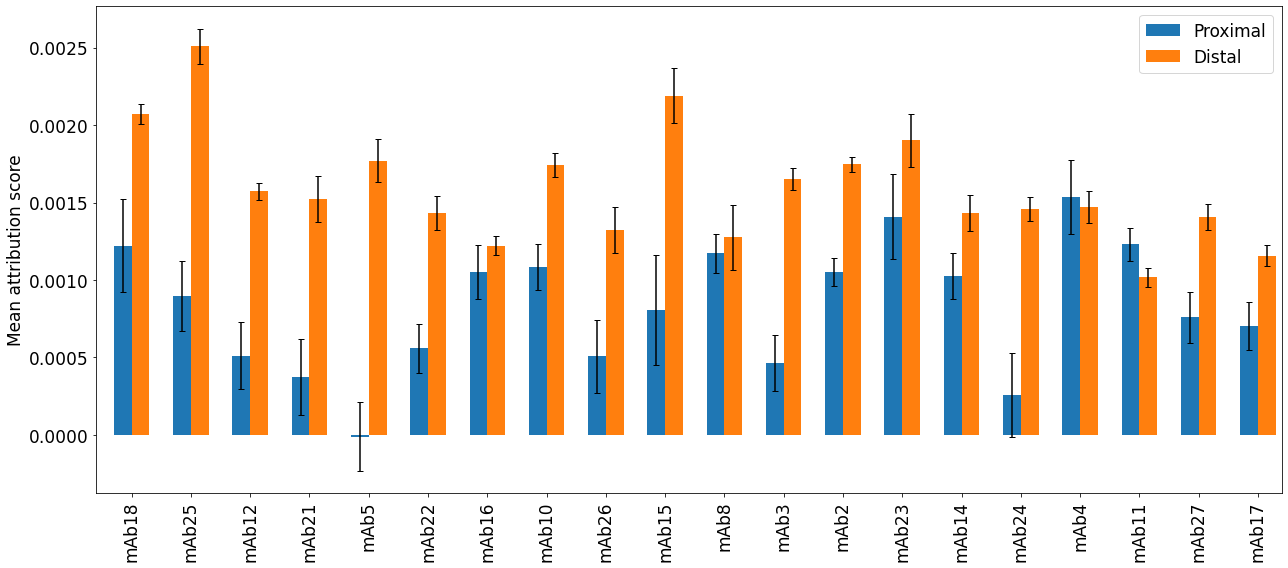

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
plot_patch_intensities(axes, df_patch_intensities_ab21)
plt.tight_layout()
plt.savefig('Fig4C.png', bbox_inches='tight', dpi=300)

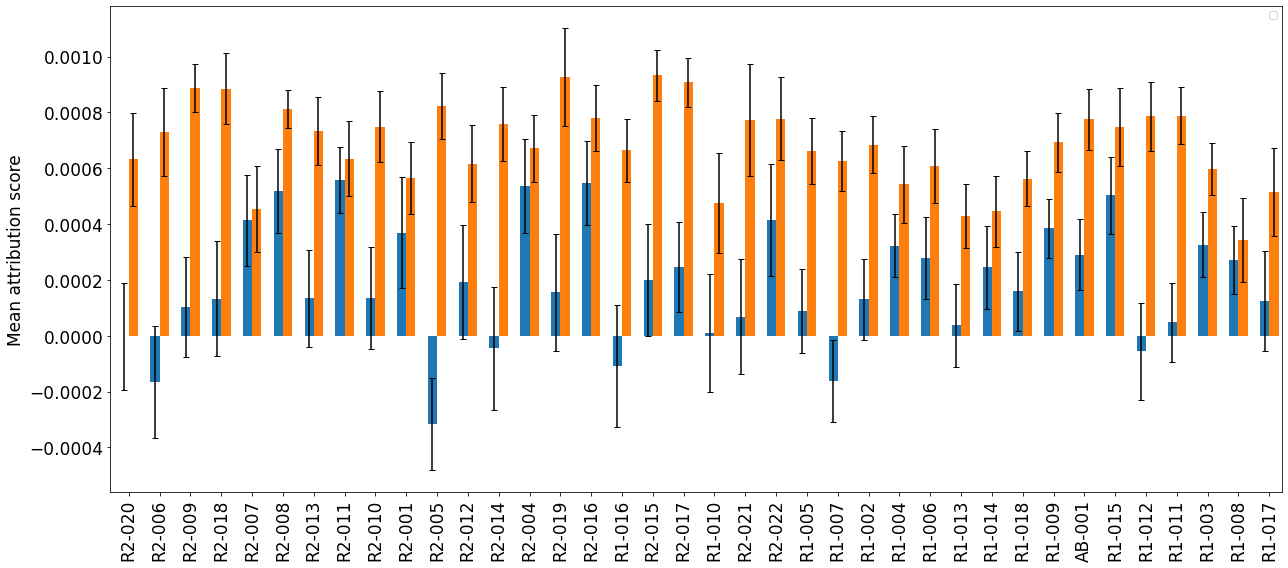

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
plot_patch_intensities(axes, df_patch_intensities_pdgf38, display_legends=False)
plt.tight_layout()
plt.savefig('Fig4D.png', bbox_inches='tight', dpi=300)

## Biochemical composition of the attribution patches

In [42]:
ATOM_TYPE_KEY = 'atom_type'
CARBOXYLATE_KEY = 'ASP/GLU'
ARG_LYS_KEY = 'ARG/LYS'
ACCEPTOR_KEY = 'Acceptor'
ACCEPTOR_MC_KEY = 'Acceptor_mainchain'
ACCEPTOR_SC_KEY = 'Acceptor_sidechain'
DONOR_KEY = 'Donor/Positive'
LIPO_KEY = 'Lipophilic'
AROMATIC_KEY = 'Aromatic'
OTHER_KEY = 'Other'
ATOM_TYPES = [CARBOXYLATE_KEY, ACCEPTOR_MC_KEY, ACCEPTOR_SC_KEY, AROMATIC_KEY, DONOR_KEY, LIPO_KEY]
ATOM_TYPES2 = [CARBOXYLATE_KEY, ACCEPTOR_KEY, AROMATIC_KEY, DONOR_KEY, LIPO_KEY]

def get_nearest_atom(mol, atom, threshold=4):
    nearest_nbr = None
    nearest_nbr_dist = 1e10
    for nbr in oechem.OEGetNearestNbrs(mol, atom, threshold):
        dist2 = nbr.GetDist2()
        if dist2 < nearest_nbr_dist:
            nearest_nbr = nbr.GetBgn()
            nearest_nbr_dist = dist2
            
    return nearest_nbr

def get_atom_type(atom):
    if atom is None:
        return LIPO_KEY
    
    if atom.IsAromatic():
        return AROMATIC_KEY   
    
    res_type = oechem.OEGetResidueIndex(atom)
    pdb_atom_type = oechem.OEGetPDBAtomIndex(atom)
    
    if res_type == oechem.OEResidueIndex_ASP:
        if pdb_atom_type in [oechem.OEPDBAtomName_CG, oechem.OEPDBAtomName_CB, 
                             oechem.OEPDBAtomName_OD1, oechem.OEPDBAtomName_OD2]:
            return CARBOXYLATE_KEY
        
    if res_type == oechem.OEResidueIndex_GLU:
        if pdb_atom_type in [oechem.OEPDBAtomName_CB, oechem.OEPDBAtomName_CG, 
                             oechem.OEPDBAtomName_CD, oechem.OEPDBAtomName_OE1, oechem.OEPDBAtomName_OE2]:
            return CARBOXYLATE_KEY
        
    if res_type == oechem.OEResidueIndex_TYR and pdb_atom_type == oechem.OEPDBAtomName_OH:
        return AROMATIC_KEY
    
    if res_type in [oechem.OEResidueIndex_ARG, oechem.OEResidueIndex_LYS]:
        if pdb_atom_type not in [oechem.OEPDBAtomName_C, oechem.OEPDBAtomName_O, oechem.OEPDBAtomName_N]:
            return DONOR_KEY#ARG_LYS_KEY
        
    if atom.IsNitrogen():
        return DONOR_KEY
    if atom.IsOxygen():
        if pdb_atom_type == oechem.OEPDBAtomName_O:
            return ACCEPTOR_MC_KEY
        else:
            return ACCEPTOR_SC_KEY
    if atom.IsCarbon() or atom.IsSulfur():
        return LIPO_KEY
        
    return LIPO_KEY

def get_patch_compositions(mol_files, save_patch_components=False):
    patch_data = collections.defaultdict(list)
    for mol_file in mol_files:
        protein_file = mol_file.replace('_neg_attr.mol2', '')
        protein_file = protein_file.replace('_pos_attr.mol2', '')
        protein_file = protein_file + '.pdb'
        
        protein_mol = get_molecule(protein_file)
        oechem.OESuppressHydrogens(protein_mol)  
        
        entity = os.path.basename(mol_file).split('_')[0]
        if entity not in patch_data[ENTITY_KEY]:
            patch_data[ENTITY_KEY].append(entity)
        
        count_map = collections.defaultdict(int)
        
        ifs = oechem.oemolistream(mol_file)
        for mol_idx, mol in enumerate(ifs.GetOEGraphMols()):
            for atom in mol.GetAtoms():
                nearest_nbr = get_nearest_atom(protein_mol, atom)
                atom_type = get_atom_type(nearest_nbr)
                atom.SetMapIdx(ATOM_TYPES.index(atom_type) + 1)
                count_map[atom_type] += 1
        
            if mol_idx == 0:
                if save_patch_components:
                    out_file = mol_file.split('.mol2')[0] + '_components.mol2'
                    ofs = oechem.oemolostream(out_file)
                    for k_idx, k in enumerate(ATOM_TYPES):
                        comp_mol = oechem.OEGraphMol()
                        oechem.OESubsetMol(comp_mol, mol, oechem.OEHasMapIdx(k_idx+1))
                        oechem.OEWriteMolecule(ofs, comp_mol)
                    ofs.close()
                
                for k in ATOM_TYPES:
                    patch_data['%s_PATCH_%d_%s' % (entity, (mol_idx + 1), k)].append(count_map[k])
                    
        
            if mol_idx >= 4:
                break

        for k in ATOM_TYPES:
            patch_data['%s_PATCH_top5_%s' % (entity, k)].append(count_map[k])  
            
        ifs.close()
        
        
    patch_data2 = []
    for entity in patch_data[ENTITY_KEY]:
        cur_data = {ENTITY_KEY:entity}
        for k in ATOM_TYPES:
            data_k = np.array(patch_data['%s_PATCH_1_%s' % (entity, k)])
            cur_data['PATCH_1_%s' % k] = np.mean(data_k)
            cur_data['PATCH_1_stderr_%s' % k] = 1.96*np.std(data_k)/np.sqrt(len(data_k))
            
            data_k = np.array(patch_data['%s_PATCH_top5_%s' % (entity, k)])
            cur_data['PATCH_top5_%s' % k] = np.mean(data_k)
            cur_data['PATCH_top5_stderr_%s' % k] = 1.96*np.std(data_k)/np.sqrt(len(data_k))
            
        # acceptor as acceptor_mainchain + acceptor_sidechain
        data_acc = np.array(patch_data['%s_PATCH_1_%s' % (entity, ACCEPTOR_MC_KEY)])
        data_acc += np.array(patch_data['%s_PATCH_1_%s' % (entity, ACCEPTOR_SC_KEY)])
        cur_data['PATCH_1_%s' % ACCEPTOR_KEY] = np.mean(data_acc)
        cur_data['PATCH_1_stderr_%s' % ACCEPTOR_KEY] = 1.96*np.std(data_acc)/np.sqrt(len(data_acc))
        
        data_acc = np.array(patch_data['%s_PATCH_top5_%s' % (entity, ACCEPTOR_MC_KEY)])
        data_acc += np.array(patch_data['%s_PATCH_top5_%s' % (entity, ACCEPTOR_SC_KEY)])
        cur_data['PATCH_top5_%s' % ACCEPTOR_KEY] = np.mean(data_acc)
        cur_data['PATCH_top5_stderr_%s' % ACCEPTOR_KEY] = 1.96*np.std(data_acc)/np.sqrt(len(data_acc))
        
        patch_data2.append(cur_data)
        
    return patch_data2



def plot_patch_compositions(df_patch, atom_types=ATOM_TYPES2, 
                            colors = plt.rcParams['axes.prop_cycle'].by_key()['color'], show_legends=False):
    FONT_SIZE = 14
    legends = ['Patch 1', 'Patch 2', 'Patch 3', 'Patch 4', 'Patch 5']

    top_cols = ['PATCH_1_%s'%k for k in atom_types]
    top_stderr_cols = ['PATCH_1_stderr_%s'%k for k in atom_types]
    topN_cols = ['PATCH_top5_%s'%k for k in atom_types]
    topN_stderr_cols = ['PATCH_top5_stderr_%s'%k for k in atom_types]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
    
    width = 0.3
    bottom = 0
    CAP_SIZE = 3
    
    ind = np.arange(0, len(df_patch))
    df_patch1 = df_patch[top_cols]
    df_patch1_stderr = df_patch[top_stderr_cols]
    handles1 = []
    for enum, (col, stderr_col) in enumerate(zip(top_cols, top_stderr_cols)):
        h = axes[0].bar(ind-width/2, df_patch1[col], width=width, color=colors[enum],
                     bottom=bottom, yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE)
        handles1.append(h)
        bottom += df_patch1[col]
        
    bottom = 0
    df_patch1 = df_patch[topN_cols]
    df_patch1_stderr = df_patch[topN_stderr_cols]
    handles2 = []
    for enum, (col, stderr_col) in enumerate(zip(topN_cols, topN_stderr_cols)):
        h = axes[1].bar(ind+width/2, df_patch1[col], width=width, bottom=bottom, 
                     color=colors[enum], yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE)
        handles2.append(h)
        bottom += df_patch1[col]
    
    axes[0].set_ylabel('Number of grid points', fontsize=FONT_SIZE)
    axes[0].set_xticks(ind)
    axes[0].set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes[0].tick_params(axis='y', which='major', labelsize=FONT_SIZE-3)
    ax0_ylim = axes[0].get_ylim()
    axes[0].set_ylim([0, ax0_ylim[1]])
    if show_legends:
        leg = axes[0].legend(atom_types, title='Patch composition', fontsize=FONT_SIZE-2)
        plt.setp(leg.get_title(),fontsize=FONT_SIZE-2)

    axes[1].set_ylabel('Number of grid points', fontsize=FONT_SIZE)
    axes[1].set_xticks(ind)
    axes[1].set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes[1].tick_params(axis='y', which='major', labelsize=FONT_SIZE-3)


### Patch biochemical composition - Ab21 

In [43]:
mol_files = glob.glob('models/pdgf38/attributions/*_pos_attr.mol2')
pos_attr_patch_comps_ab21 = get_patch_compositions(mol_files, False)

df_patch_comps_ab21 = pd.DataFrame(pos_attr_patch_comps_ab21)

df_ab21 = pd.read_csv('data/Ab21.csv')
df_patch_comps_ab21 = df_ab21.merge(df_patch_comps_ab21, on=ENTITY_KEY)
df_patch_comps_ab21 = df_patch_comps_ab21.sort_values(VISCOSITY_KEY)
df_patch_comps_ab21.head()

,Entity,Viscosity_at_150,Isotype,N_hydrophobic Fv,N_hydrophobic mAb,N_hydrophilic Fv,N_hydrophilic mAb,HI_Fv,HI_mAb,SASA_phobic_Fv,...,PATCH_top5_Donor/Positive,PATCH_top5_stderr_Donor/Positive,PATCH_1_Lipophilic,PATCH_1_stderr_Lipophilic,PATCH_top5_Lipophilic,PATCH_top5_stderr_Lipophilic,PATCH_1_Acceptor,PATCH_1_stderr_Acceptor,PATCH_top5_Acceptor,PATCH_top5_stderr_Acceptor
13,mAb18,7.1,IgG1,84,496,117,706,1.256007,1.042884,4420.116699,...,8.12,0.981285,2.53,0.475642,11.23,1.213889,27.62,2.192009,80.47,3.020239
18,mAb25,7.4,IgG1,77,480,125,724,1.073215,1.001049,4446.611328,...,1.31,0.255094,2.33,0.448712,3.51,0.519674,20.29,1.380735,44.40,2.542869
8,mAb12,7.5,IgG1,87,492,120,726,1.171067,0.992760,5444.043945,...,19.73,1.739406,15.64,2.288508,30.29,2.766350,54.54,2.777870,140.65,9.122337
14,mAb21,8.6,IgG1,80,486,119,710,1.187628,1.033930,3921.662598,...,7.88,0.681381,10.77,3.337283,41.51,3.656174,28.89,2.520090,94.67,5.163181
4,mAb5,8.6,IgG1,89,504,112,700,1.273285,1.052817,5683.704590,...,36.61,2.218162,14.63,0.901453,41.33,2.308486,111.16,6.301802,185.41,9.530966


In [44]:
df_patch_comps_ab21_2 = df_patch_comps_ab21.copy()
df_patch_comps_ab21_2['frac_aromatic'] = df_patch_comps_ab21_2.apply(lambda x: x['PATCH_top5_Aromatic']/np.sum(np.array([x['PATCH_top5_%s' % t] for t in ATOM_TYPES])), axis=1)
df_tmp = df_patch_comps_ab21_2[df_patch_comps_ab21_2[VISCOSITY_KEY] > 90.0]
df_tmp2 = df_patch_comps_ab21_2[df_patch_comps_ab21_2[VISCOSITY_KEY] < 90.0]

print('frac_aromatic mAb4: %.2f' % df_patch_comps_ab21_2.loc[df_patch_comps_ab21_2[ENTITY_KEY]=='mAb4','frac_aromatic'].values[0])

high_aro = np.mean(df_tmp['frac_aromatic'])
low_aro = np.mean(df_tmp2['frac_aromatic'])
print('Ab21 - fraction aromatic content, high: %.2f, low: %.2f' % (high_aro, low_aro))

frac_neg_acc = np.mean((df_patch_comps_ab21['PATCH_top5_ASP/GLU']+df_patch_comps_ab21['PATCH_top5_Acceptor'])/df_patch_comps_ab21[['PATCH_top5_%s' % t for t in ATOM_TYPES2]].sum(axis=1))
print('Ab21 - fraction neg_acc: %.2f' % frac_neg_acc)

frac_aromatic mAb4: 0.10
Ab21 - fraction aromatic content, high: 0.10, low: 0.04
Ab21 - fraction neg_acc: 0.89


In [45]:
mol_files = glob.glob('models/ab21/attributions/*_pos_attr.mol2')
pos_attr_patch_comps_pdgf38 = get_patch_compositions(mol_files, False)

df_patch_comps_pdgf38 = pd.DataFrame(pos_attr_patch_comps_pdgf38)

df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_patch_comps_pdgf38 = df_pdgf38.merge(df_patch_comps_pdgf38, on=ENTITY_KEY)
df_patch_comps_pdgf38 = df_patch_comps_pdgf38.sort_values(VISCOSITY_KEY)
df_patch_comps_pdgf38.head()

,Entity,Viscosity_at_150,SCM,HC,LC,PATCH_1_ASP/GLU,PATCH_1_stderr_ASP/GLU,PATCH_top5_ASP/GLU,PATCH_top5_stderr_ASP/GLU,PATCH_1_Acceptor_mainchain,...,PATCH_top5_Donor/Positive,PATCH_top5_stderr_Donor/Positive,PATCH_1_Lipophilic,PATCH_1_stderr_Lipophilic,PATCH_top5_Lipophilic,PATCH_top5_stderr_Lipophilic,PATCH_1_Acceptor,PATCH_1_stderr_Acceptor,PATCH_top5_Acceptor,PATCH_top5_stderr_Acceptor
35,R2-020,10,-1363,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,139.23,13.589398,362.70,20.498161,80.09,...,54.60,5.442098,26.07,4.656166,58.90,6.429905,97.61,12.347406,212.83,15.620869
21,R2-006,13,-1470,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,162.56,10.978846,382.91,13.338548,90.73,...,53.25,4.830068,35.21,4.478700,75.66,7.468769,120.50,13.374771,248.91,14.917212
24,R2-009,19,-1469,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,119.00,11.042439,366.59,17.150506,81.41,...,55.92,3.888087,28.05,3.833329,72.86,7.216262,104.87,11.947728,247.46,13.799832
33,R2-018,20,-1346,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGNSLGSYFVHWYQQKPGQSPVLV...,127.30,13.542182,357.32,17.708248,90.92,...,52.12,6.327145,49.35,6.549414,80.20,7.595904,117.88,17.940999,232.97,20.120437
22,R2-007,21,-1433,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,118.81,13.368973,328.69,20.752998,99.27,...,61.66,5.342086,44.13,5.659118,84.11,7.337937,124.06,15.477395,250.03,17.909756


In [46]:
df_patch_comps_pdgf38_2 = df_patch_comps_pdgf38.copy()
df_patch_comps_pdgf38_2['frac_aromatic'] = df_patch_comps_pdgf38_2.apply(lambda x: x['PATCH_top5_Aromatic']/np.sum(np.array([x['PATCH_top5_%s' % t] for t in ATOM_TYPES])), axis=1)
df_tmp = df_patch_comps_pdgf38_2[df_patch_comps_pdgf38_2[VISCOSITY_KEY] > 90.0]
df_tmp2 = df_patch_comps_pdgf38_2[df_patch_comps_pdgf38_2[VISCOSITY_KEY] < 90.0]

print('frac_aromatic R1-003: %.2f' % df_patch_comps_pdgf38_2.loc[df_patch_comps_pdgf38_2[ENTITY_KEY]=='R1-003','frac_aromatic'].values[0])

all_aro = np.mean(df_patch_comps_pdgf38_2['frac_aromatic'])
high_aro = np.mean(df_tmp['frac_aromatic'])
low_aro = np.mean(df_tmp2['frac_aromatic'])
print('PDGF38 - fraction aromatic content, all: %.2f, high: %.2f, low: %.2f' % (all_aro, high_aro, low_aro))

df_tmp = pd.concat([df_patch_comps_ab21, df_patch_comps_pdgf38])
frac_mainchain_acc = np.mean(df_tmp['PATCH_top5_Acceptor_mainchain']/df_tmp['PATCH_top5_Acceptor'])
print('fraction mainchain acceptor: %.2f' % frac_mainchain_acc)

frac_neg_acc = np.mean((df_patch_comps_pdgf38['PATCH_top5_ASP/GLU']+df_patch_comps_pdgf38['PATCH_top5_Acceptor'])/df_patch_comps_pdgf38[['PATCH_top5_%s' % t for t in ATOM_TYPES2]].sum(axis=1))
print('PDGF38 - fraction neg_acc: %.2f' % frac_neg_acc)

frac_aromatic R1-003: 0.17
PDGF38 - fraction aromatic content, all: 0.16, high: 0.16, low: 0.16
fraction mainchain acceptor: 0.73
PDGF38 - fraction neg_acc: 0.68


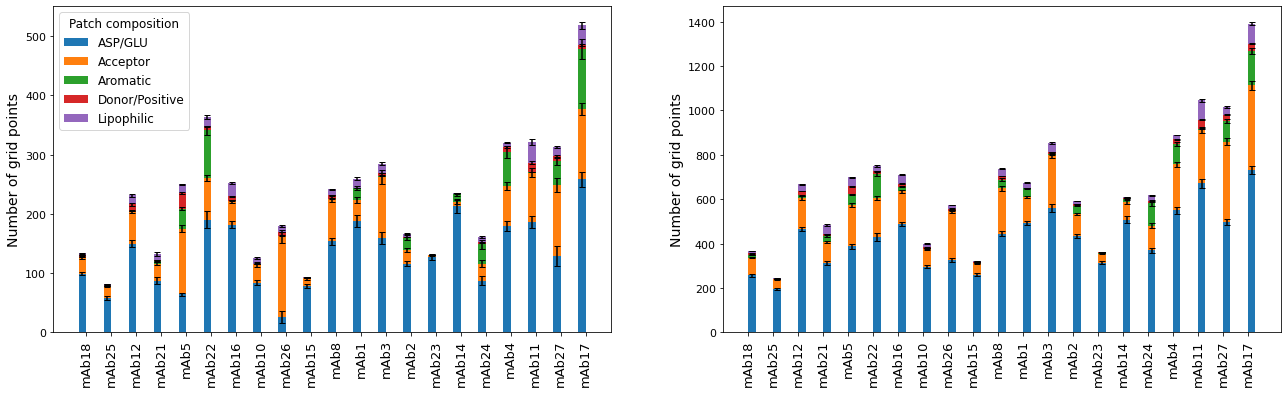

In [47]:
plot_patch_compositions(df_patch_comps_ab21, show_legends=True)
plt.savefig('Fig5AB.png', bbox_inches='tight', dpi=300)

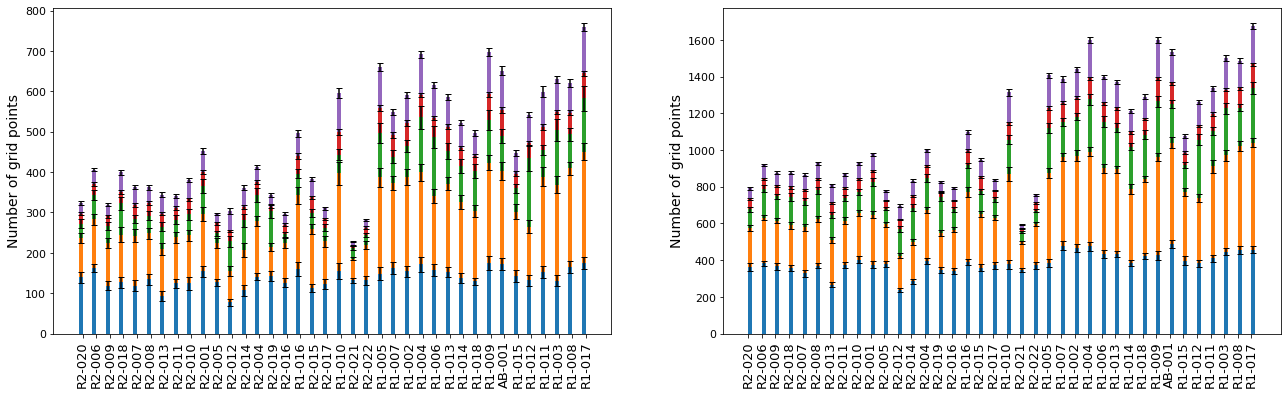

In [48]:
plot_patch_compositions(df_patch_comps_pdgf38)
plt.savefig('Fig5CD.png', bbox_inches='tight', dpi=300)

### Biochemical composition of positive-attribution patches (separate mainchain and sidechain acceptors)

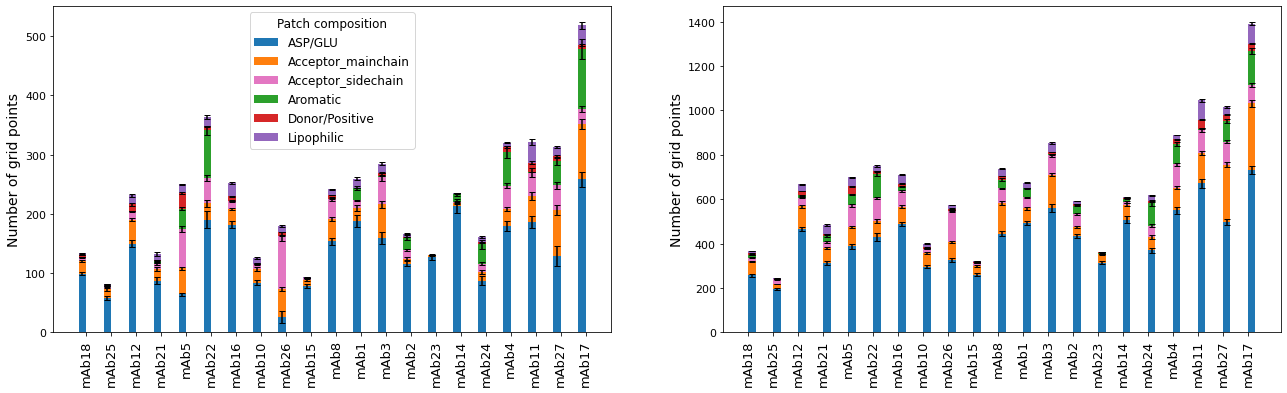

In [49]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_patch_compositions(df_patch_comps_ab21, ATOM_TYPES, colors[:2] + [colors[6]] + colors[2:6], show_legends=True)
plt.savefig('Suppl_fig5AB.png', bbox_inches='tight', dpi=300)

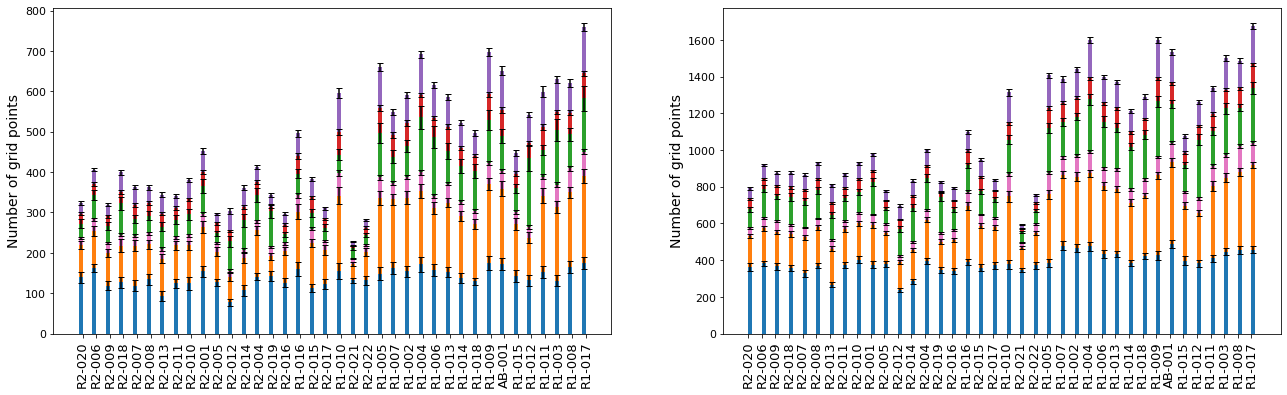

In [50]:
plot_patch_compositions(df_patch_comps_pdgf38, ATOM_TYPES, colors[:2] + [colors[6]] + colors[2:6])
plt.savefig('Suppl_fig5CD.png', bbox_inches='tight', dpi=300)

### Attribution by segment

In [51]:

L1_KEY = 'L1'
L2_KEY = 'L2'
L3_KEY = 'L3'
H1_KEY = 'H1'
H2_KEY = 'H2'
H3_KEY = 'H3'

def get_segment_residue_keys(protein_mol, protein_sdmol, sdkey):
    try:
        value = oechem.OEGetSDData(protein_sdmol, sdkey)
        res_start, res_end = value.split('_')
        res_start = res_start.replace(':', '')
        res_end = res_end.replace(':', '')

        segment_residues = [res_start]
        hv = oechem.OEHierView(protein_mol)
        include_residue = False
        for hr in hv.GetResidues():
            oeres = hr.GetOEResidue()
            resnum = oeres.GetResidueNumber()
            reskey = oeres.GetChainID() + str(resnum)
            if reskey == res_start:
                include_residue = True
                continue
            if reskey == res_end:
                break
            if include_residue:
                segment_residues.append(reskey)
        segment_residues.append(reskey)

        return segment_residues
    except Exception as e:
        return []
    
    

def extract_segment_data(protein_mol, protein_sdfile):        
    protein_sdmol = get_molecule(protein_sdfile)

    L1_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L1_Chothia')
    L2_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L2_Chothia')
    L3_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_L3_Chothia')
    H1_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H1_Chothia')
    H2_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H2_Chothia')
    H3_residues = get_segment_residue_keys(protein_mol, protein_sdmol, 's_bioluminateReadOnly_H3_Chothia')   
    
    return {L1_KEY:L1_residues, L2_KEY:L2_residues, L3_KEY:L3_residues, H1_KEY:H1_residues, H2_KEY:H2_residues, H3_KEY:H3_residues}
    

UNKNOWN_SEGMENT_TYPE = 'FW'
SEGMENT_TYPES = [L1_KEY, L2_KEY, L3_KEY, H1_KEY, H2_KEY, H3_KEY, UNKNOWN_SEGMENT_TYPE]

def get_segment_type(atom, segment_data):
    oeres = oechem.OEAtomGetResidue(atom)
    reskey = oeres.GetChainID() + str(oeres.GetResidueNumber())
    
    for segment_type, segment_residues in segment_data.items():
        if reskey in segment_residues:
            return segment_type
        
    return UNKNOWN_SEGMENT_TYPE

 
def get_patch_segments(mol_files, save_patch_components=False):
    patch_data = collections.defaultdict(list)
    for mol_file in mol_files:
        protein_file = mol_file.replace('_neg_attr.mol2', '')
        protein_file = protein_file.replace('_pos_attr.mol2', '')
        protein_file = protein_file + '.pdb'
        
        protein_mol = get_molecule(protein_file)
        oechem.OESuppressHydrogens(protein_mol) 

        protein_sdfile = os.path.join(HM_DIR, os.path.basename(mol_file).split('_')[0] + '.sdf')
        segment_data = extract_segment_data(protein_mol, protein_sdfile)
                
        entity = os.path.basename(mol_file).split('_')[0]
        if entity not in patch_data[ENTITY_KEY]:
            patch_data[ENTITY_KEY].append(entity)
        
        count_map = collections.defaultdict(int)
        
        ifs = oechem.oemolistream(mol_file)
        for mol_idx, mol in enumerate(ifs.GetOEGraphMols()):
            for atom in mol.GetAtoms():
                nearest_nbr = get_nearest_atom(protein_mol, atom)
                if nearest_nbr is None:
                    continue
                segment_type = get_segment_type(nearest_nbr, segment_data)
                atom.SetMapIdx(SEGMENT_TYPES.index(segment_type) + 1)
                count_map[segment_type] += 1
            
            if mol_idx == 0:
                for k_idx, k in enumerate(SEGMENT_TYPES):
                    patch_data['%s_PATCH_%d_%s' % (entity, (mol_idx + 1), k)].append(count_map[k])
                    
            if mol_idx >= 4:
                break

        for k in SEGMENT_TYPES:
            patch_data['%s_PATCH_top5_%s' % (entity, k)].append(count_map[k])   
            
        ifs.close()
        
        
    patch_data2 = []
    for entity in patch_data[ENTITY_KEY]:
        cur_data = {ENTITY_KEY:entity}
        for k in SEGMENT_TYPES:
            data_k = np.array(patch_data['%s_PATCH_1_%s' % (entity, k)])
            cur_data['PATCH_1_%s' % k] = np.mean(data_k)
            cur_data['PATCH_1_stderr_%s' % k] = 1.96*np.std(data_k)/np.sqrt(len(data_k))
            
            data_k = np.array(patch_data['%s_PATCH_top5_%s' % (entity, k)])
            cur_data['PATCH_top5_%s' % k] = np.mean(data_k)
            cur_data['PATCH_top5_stderr_%s' % k] = 1.96*np.std(data_k)/np.sqrt(len(data_k))
                    
        patch_data2.append(cur_data)
        
    return patch_data2


def plot_patch_segments(df_patch, segment_types=SEGMENT_TYPES, 
                            colors = plt.rcParams['axes.prop_cycle'].by_key()['color'], show_legends=False):
    FONT_SIZE = 14
    legends = ['Patch 1', 'Patch 2', 'Patch 3', 'Patch 4', 'Patch 5']

    top_cols = ['PATCH_1_%s'%k for k in segment_types]
    top_stderr_cols = ['PATCH_1_stderr_%s'%k for k in segment_types]
    topN_cols = ['PATCH_top5_%s'%k for k in segment_types]
    topN_stderr_cols = ['PATCH_top5_stderr_%s'%k for k in segment_types]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))
    
    width = 0.3
    bottom = 0
    CAP_SIZE = 3
    
    ind = np.arange(0, len(df_patch))
    df_patch1 = df_patch[top_cols]
    df_patch1_stderr = df_patch[top_stderr_cols]
    handles1 = []
    for enum, (col, stderr_col) in enumerate(zip(top_cols, top_stderr_cols)):
        h = axes[0].bar(ind-width/2, df_patch1[col], width=width, color=colors[enum],
                     bottom=bottom, yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE)
        handles1.append(h)
        bottom += df_patch1[col]
        
    bottom = 0
    df_patch1 = df_patch[topN_cols]
    df_patch1_stderr = df_patch[topN_stderr_cols]
    handles2 = []
    for enum, (col, stderr_col) in enumerate(zip(topN_cols, topN_stderr_cols)):
        h = axes[1].bar(ind+width/2, df_patch1[col], width=width, bottom=bottom, 
                     color=colors[enum], yerr=df_patch1_stderr[stderr_col], capsize=CAP_SIZE)
        handles2.append(h)
        bottom += df_patch1[col]
        
        
    axes[0].set_ylabel('Number of grid points', fontsize=FONT_SIZE)
    axes[0].set_xticks(ind)
    axes[0].set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes[0].tick_params(axis='y', which='major', labelsize=FONT_SIZE-3)
    ax0_ylim = axes[0].get_ylim()
    axes[0].set_ylim([0, ax0_ylim[1]])
    if show_legends:
        leg = axes[0].legend(segment_types, title='Patch composition', fontsize=FONT_SIZE-2)
        plt.setp(leg.get_title(),fontsize=FONT_SIZE-2)

    axes[1].set_ylabel('Number of grid points', fontsize=FONT_SIZE)
    axes[1].set_xticks(ind)
    axes[1].set_xticklabels(df_patch[ENTITY_KEY].values, rotation=90, fontsize=FONT_SIZE-1)
    axes[1].tick_params(axis='y', which='major', labelsize=FONT_SIZE-3)
    ax1_ylim = axes[1].get_ylim()
    axes[1].set_ylim([0, ax1_ylim[1]])


In [52]:
mol_files = glob.glob('models/pdgf38/attributions/*_pos_attr.mol2')
patch_segments_ab21 = get_patch_segments(mol_files)

df_patch_segments_ab21 = pd.DataFrame(patch_segments_ab21)

df_ab21 = pd.read_csv('data/Ab21.csv')
df_patch_segments_ab21 = df_ab21.merge(df_patch_segments_ab21, on=ENTITY_KEY)
df_patch_segments_ab21 = df_patch_segments_ab21.sort_values(VISCOSITY_KEY)
df_patch_segments_ab21.head()

,Entity,Viscosity_at_150,Isotype,N_hydrophobic Fv,N_hydrophobic mAb,N_hydrophilic Fv,N_hydrophilic mAb,HI_Fv,HI_mAb,SASA_phobic_Fv,...,PATCH_top5_H2,PATCH_top5_stderr_H2,PATCH_1_H3,PATCH_1_stderr_H3,PATCH_top5_H3,PATCH_top5_stderr_H3,PATCH_1_FW,PATCH_1_stderr_FW,PATCH_top5_FW,PATCH_top5_stderr_FW
13,mAb18,7.1,IgG1,84,496,117,706,1.256007,1.042884,4420.116699,...,41.34,5.131550,0.00,0.000000,16.83,2.358696,133.21,3.806368,304.40,8.111322
18,mAb25,7.4,IgG1,77,480,125,724,1.073215,1.001049,4446.611328,...,0.00,0.000000,0.00,0.000000,0.00,0.000000,60.09,8.580418,154.34,5.608698
8,mAb12,7.5,IgG1,87,492,120,726,1.171067,0.992760,5444.043945,...,4.04,1.415799,0.00,0.000000,34.63,5.163300,231.57,7.480129,583.68,15.384012
14,mAb21,8.6,IgG1,80,486,119,710,1.187628,1.033930,3921.662598,...,30.13,3.238411,2.76,1.215238,16.30,4.424437,90.05,10.721590,317.15,11.444634
4,mAb5,8.6,IgG1,89,504,112,700,1.273285,1.052817,5683.704590,...,0.00,0.000000,47.28,2.926127,62.22,3.221036,22.16,6.492881,441.35,10.616919


In [53]:
mol_files = glob.glob('models/ab21/attributions/*_pos_attr.mol2')
patch_segments_pdgf38 = get_patch_segments(mol_files)

df_patch_segments_pdgf38 = pd.DataFrame(patch_segments_pdgf38)

df_pdgf38 = pd.read_csv('data/PDGF38.csv')
df_patch_segments_pdgf38 = df_pdgf38.merge(df_patch_segments_pdgf38, on=ENTITY_KEY)
df_patch_segments_pdgf38 = df_patch_segments_pdgf38.sort_values(VISCOSITY_KEY)
df_patch_segments_pdgf38.head()

,Entity,Viscosity_at_150,SCM,HC,LC,PATCH_1_L1,PATCH_1_stderr_L1,PATCH_top5_L1,PATCH_top5_stderr_L1,PATCH_1_L2,...,PATCH_top5_H2,PATCH_top5_stderr_H2,PATCH_1_H3,PATCH_1_stderr_H3,PATCH_top5_H3,PATCH_top5_stderr_H3,PATCH_1_FW,PATCH_1_stderr_FW,PATCH_top5_FW,PATCH_top5_stderr_FW
35,R2-020,10,-1363,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,8.20,4.670397,25.84,6.295093,3.53,...,132.90,21.146638,25.56,8.761148,76.69,12.751414,227.60,35.727160,512.00,41.725486
21,R2-006,13,-1470,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,1.82,1.988290,41.75,9.575613,1.23,...,167.53,14.888841,54.43,14.968762,124.86,20.896487,248.26,46.525162,519.59,36.703878
24,R2-009,19,-1469,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,8.16,5.212179,58.08,12.652333,4.42,...,143.34,16.110752,27.80,9.425542,82.07,10.908391,221.10,35.284306,526.23,38.677310
33,R2-018,20,-1346,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGNSLGSYFVHWYQQKPGQSPVLV...,11.94,5.563695,56.74,12.677719,6.82,...,129.20,16.597254,53.46,13.828086,103.62,17.069243,260.04,48.227168,520.73,55.923563
22,R2-007,21,-1433,EVQLLQSGGGLVKPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...,SYVLTQPPSVSVAPGKTARITCSGDSLGSYFVHWYQQKPGQSPVLV...,15.43,6.667300,86.18,14.914438,6.16,...,108.04,17.681176,21.89,9.171036,81.00,14.428423,298.27,42.154509,510.54,47.951154


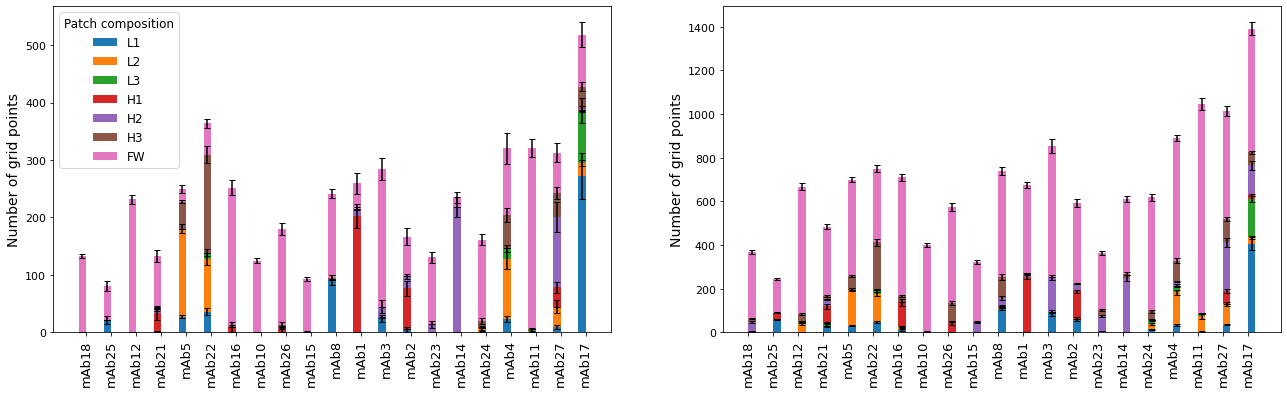

In [54]:
plot_patch_segments(df_patch_segments_ab21, show_legends=True)
plt.savefig('Suppl_fig4AB.png', bbox_inches='tight', dpi=300)

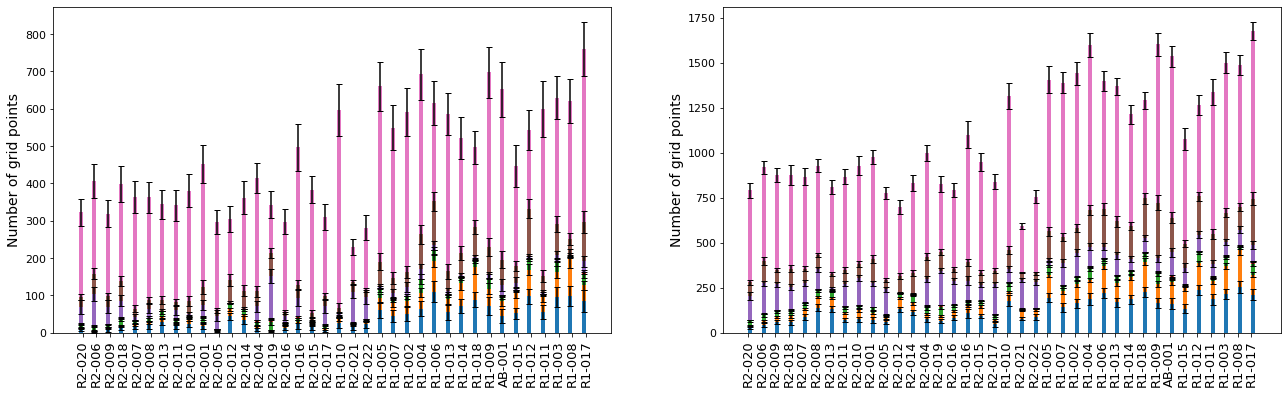

In [55]:
plot_patch_segments(df_patch_segments_pdgf38)
plt.savefig('Suppl_fig4CD.png', bbox_inches='tight', dpi=300)